# 3.11 模型选择、欠拟合和过拟合


## 3.11.4 多项式函数拟合实验

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 3.11.4.1 生成数据集

In [0]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = tf.random.normal(shape=(n_train + n_test, 1))
poly_features = tf.concat([features, tf.pow(features, 2), tf.pow(features, 3)], axis=1)
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1] + true_w[2] * poly_features[:, 2] + true_b)
labels += tf.random.normal(labels.shape, stddev=0.1)

看一看生成的数据集的前两个样本。

In [5]:
features[:2], poly_features[:2], labels[:2]

(<tf.Tensor: id=44, shape=(2, 1), dtype=float32, numpy=
 array([[1.1342491 ],
        [0.87351704]], dtype=float32)>,
 <tf.Tensor: id=48, shape=(2, 3), dtype=float32, numpy=
 array([[1.1342491 , 1.286521  , 1.4592353 ],
        [0.87351704, 0.76303196, 0.66652143]], dtype=float32)>,
 <tf.Tensor: id=52, shape=(2,), dtype=float32, numpy=array([10.027682 ,  7.3448544], dtype=float32)>)

### 3.11.4.2. 定义、训练和测试模型¶

In [0]:
from IPython import display
def use_svg_display():
    """Use svg format to display plot in jupyter"""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set matplotlib figure size."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [0]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

和线性回归一样，多项式函数拟合也使用平方损失函数。因为我们将尝试使用不同复杂度的模型来拟合生成的数据集，所以我们把模型定义部分放在fit_and_plot函数中。多项式函数拟合的训练和测试步骤与3.6节（softmax回归的从零开始实现）介绍的softmax回归中的相关步骤类似。

In [0]:
num_epochs, loss = 100, tf.losses.MeanSquaredError()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1))
    batch_size = min(10, train_labels.shape[0])
    train_iter = tf.data.Dataset.from_tensor_slices(
        (train_features, train_labels)).batch(batch_size)
    test_iter = tf.data.Dataset.from_tensor_slices(
        (test_features, test_labels)).batch(batch_size)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                l = loss(y, net(X))

            grads = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(grads, net.trainable_variables))

        train_ls.append(loss(train_labels, net(train_features)).numpy().mean())
        test_ls.append(loss(test_labels, net(test_features)).numpy().mean())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.get_weights()[0],
          '\nbias:', net.get_weights()[1])

### 3.11.4.3. 三阶多项式函数拟合（正常）¶

final epoch: train loss 0.0076061427 test loss 0.009977359


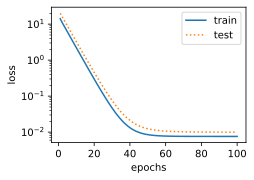

weight: [[ 1.1857017]
 [-3.3969326]
 [ 5.6001344]] 
bias: [4.9984303]


In [12]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:])

### 3.11.4.4. 线性函数拟合（欠拟合）¶

final epoch: train loss 175.32323 test loss 394.3198


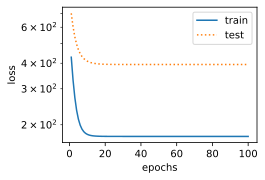

weight: [[18.400213]] 
bias: [-1.3679209]


In [15]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

### 3.11.4.5. 训练样本不足（过拟合）

final epoch: train loss 0.14469022 test loss 201.26407


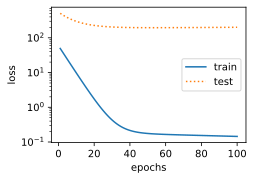

weight: [[2.843685  ]
 [0.80718964]
 [2.8566866 ]] 
bias: [1.8927275]


In [14]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])